# About utils_timeline_viz.ipynb

This notebook defines and demontrastes some of the parsed **log cleaning functions** including:
* loading a log file as a dataframe from the data folders using a student id and sim
* loading a log file as a dataframe from a file path
* removing model events
* adding pause events
* adding family of actions for each action type

This notebook also shows how to make **sequences of actions** from these families and plot those sequences.
Finally notebook ends by showing how to visualize clean log data

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import getpass
import json
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

## Let's get a sense of the data
We either use *find_student_log_file* to pull up a log file given the student id and sim or we import a txt file directly.

In [2]:
def find_student_log_file(sim, studentid, date=None, infolder = FOLDER):
    if date:
        for root, dirs, files in os.walk(infolder):
            for f in files:
                if sim in f and studentid in f and date in f:
                    return os.path.join(root, f)
    else:
        for root, dirs, files in os.walk(infolder):
            for f in files:
                if sim in f and studentid in f:
                    return os.path.join(root, f)

In [3]:
studentid = '90447168'
sim = 'beers'
# parsed_file = find_student_log_file(sim,studentid)
parsed_file = 'dream_table_beers-law-lab_90447168_2017-01-17_11.22.45.txt'
df = pd.read_table(parsed_file, sep='\t')

In [4]:
df.head(n=5)

,User,Sim,Time,Index,User or Model,Component,Event,Item,Action,Laser toggle,Wavelength,Width,Concentration,Absorbance,Detector location,Ruler location,diff in parsed table,Table,X axis,Y axis,X axis scale,Y axis scale,Notes
0,90447168,beers-law-lab,0.00e+00,0,model,interface,initializing,NaN,beersLawLab.sim.simStarted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,NaN,NaN
1,90447168,beers-law-lab,1.00e-03,2,model,sim,updating state,NaN,NaN,0.0,780.0,1.0,100.0,NaN,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN
2,90447168,beers-law-lab,1.50e-02,17,model,interface,initializing,NaN,beersLawLab.navigationBar.titleTextNode.textCh...,0.0,780.0,1.0,100.0,NaN,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN
3,90447168,beers-law-lab,3.06e+00,572,user,sim,toggle laser,laser button,NaN,0.0,780.0,1.0,100.0,NaN,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN
4,90447168,beers-law-lab,3.08e+00,574,model,sim,updating state,NaN,NaN,1.0,780.0,1.0,100.0,0.96,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN


In [5]:
# There are user and model actions, but how many of each?
df.groupby('User or Model')['Event'].count()

User or Model
model    2036
user     3844
Name: Event, dtype: int64

In [6]:
#Which events are user or model actions?
print "User actions: ", ", ".join(df[df['User or Model']=='user']['Event'].unique())
print "Model actions: ", ", ".join(df[df['User or Model']=='model']['Event'].unique())

User actions:  toggle laser, dragStarted, dragged, dragEnded, editing notes, recording data, expanding table, expanding graph, Adding data to graph, Selecting Y-axis, Selecting X-axis, Changed concentration, Removing data from table, Selecting scale of Y-axis
Model actions:  initializing, updating state


In [7]:
#list all possible items for the events to inform action to family dictionary
all_items = df['Item'].unique()
all_items.sort()
print all_items

[nan 'X-axis dropdown menu' 'Y-axis dropdown menu'
 'Y-axis scale dropdown menu' 'cuvetteNode' 'detectorNode' 'graph'
 'laser button' 'solutionControls' 'solutionsControls slider' 'table'
 'trialNumber 1' 'trialNumber 10' 'trialNumber 11' 'trialNumber 12'
 'trialNumber 13' 'trialNumber 14' 'trialNumber 15' 'trialNumber 16'
 'trialNumber 17' 'trialNumber 18' 'trialNumber 19' 'trialNumber 2'
 'trialNumber 20' 'trialNumber 3' 'trialNumber 4' 'trialNumber 5'
 'trialNumber 6' 'trialNumber 7' 'trialNumber 8' 'trialNumber 9'
 'wavelengthControls']


## Let's massage the data
### First, we don't care to visualize model actions so we ignore them

In [8]:
def remove_model_events(df):
    return df[df['User or Model'] != 'model']

In [9]:
df = remove_model_events(df)
df.groupby('User or Model')['Event'].count()

User or Model
user    3844
Name: Event, dtype: int64

### Next we add pauses

In [10]:
def add_pauses(df,pause_length=15):

    def detect_pause(row,current_time,next_time):
        duration_of_action = next_time - current_time
        if duration_of_action >= pause_length:
            row['Family']='Pause'
            return row

    df['Timeshifted'] = df[['Time']].shift(-1)
    df_pauses = df.loc[df['Timeshifted']-df['Time']>=pause_length]
    df_pauses.loc[:,('User or Model')]='user'
    df_pauses.loc[:,('Event')]='Pause'
    df_pauses.loc[:,('Item')]='Pause'
    df_pauses.loc[:,('Action')]='Pause'
    df_pauses.loc[:,('Time')]=df_pauses[('Time')]+2 #shift it by 2 sec since otherwise the original event and pause have the same start time
    df = pd.concat([df,df_pauses],ignore_index=True)
    df = df.sort_values('Time')
    #Now that we added pauses, we have to recreate the time shifted column to calculate durations
    df['Timeshifted'] = df[['Time']].shift(-1)
    df['Duration'] = df['Timeshifted']-df['Time']
    df['Duration'] = df['Duration'].fillna(2) # the last duration will be NaN so we replace wiht 2 seconds
    return df

In [11]:
#Let's try and add pauses to the mix.
pause_length = 15
df = add_pauses(df,pause_length=pause_length)

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Making the sequences and viz
### We define action familes
We populate family column based on action_to_family dict above.

First we reverse the dictionary to map events to families.

We populate family column based on action_to_family dict above.

First we reverse the dictionary to map events to families.

In [12]:
action_to_family = {'N':['editing notes'],
                    'R':['Restoring sim state from trial'],
                    'M':['recording data'],
                   'Dt':['Removing data from table'],
                    'Ga':['Adding data to graph'],
                    'Ge':['Selecting Y-axis','Selecting X-axis', 'Selecting scale of Y-axis','Selecting scale of X-axis'],
                    'Gr':['Removing data from graph'],
                   'I':['expanding table','collapsing table','expanding graph','collapsing graph','collapsing simulation','expanding simulation','Playing with PhET menu'],
                    'P':['Pause']}
variable_actions = ['toggle laser','dragEnded','dragged','dragStarted','Changed concentration','Changed wavelength']
family_full_names = {'I':'Interface',
                     'R':'Restore from trial',
                    'P':'Pause',
                    'G':'Graph (add/del/edit)',
                    'Dt':'Data Table (del/move)',
                    'N':'Notes',
                    'M':'Record',
                    'Vd':'Detector',
                    'Vw':'Wavelength',
                    'Vc':'Width', #c = cuvetteNode
                    'Vs':'Concentration', #s = 
                    'Vl':'Laser toggle',
                    }
def add_family(df):
    event_to_family = {}
    for family, events in action_to_family.iteritems():
        for event in events:
            event_to_family[event]=family

    def map_event_family(event,item):
        if event in variable_actions:
            return 'V'+item[0]
        else:
            try:
                return event_to_family[event]
            except KeyError:
                print("New event found:",event)

    df['Family'] = df.apply(lambda row: map_event_family(row['Event'],row['Item']), axis=1)
    return df

df = add_family(df)

### All of these data cleaning steps can be packaged into one

In [13]:
def prep_parsing_data(parsing_file):
    df = pd.read_table(parsing_file, sep='\t')
    df = remove_model_events(df)
    if len(df)==0:
        print "The parsed file has no user events, only model events. No dataframe prepared."
        return None
    df = add_pauses(df)
    df = add_family(df)
    return df

## We package log data into sequences

In [14]:
def get_blocks_withTime(df, students, ignore=[], add_spaces=False):
    
    '''
    This function gets action sequences in block form along with time stamps for each block for plotting.
    '''
    blocks = {student:'' for student in students}
    time_coords = {student:[] for student in students}
    for student in students:
        sequence =  list(df['Family'])
#         print sequence
        time_stamps =  list(df['Time'])
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'([A-Z][a-z]{0,3})\1*')  #this regex finds all action blocks of length 1+
#         print ''.join([action for action in sequence if action not in ignore])
        #print time_stamps
        ##use finditer to return a sequence of matches as an iterator
        previous_start = 0
        for match in p.finditer(''.join([action for action in sequence if action not in ignore])):
            ind = match.span()  #this gives start and end of matched block
            ##for matches of action denoted by more than 1 letter (e.g. Tb), need to correct the span
#             print match.group(), match.span(), ind[1]-ind[0], len(set(match.group())),
            ##set() function yields unique elements of a set, which allows picking out those actions with > 1 letter
            ##for e.g. if match.group() gives "CCCCC", then set() of that is "C" while for "TbTbTb" we'd have "T","b"
            ind = (previous_start, previous_start + (ind[1]-ind[0])/len(set(match.group())))
            #print ind
            previous_start = ind[1]
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
                #print time_stamps[ind[1]-1], time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
                #print time_stamps[ind[1]] , time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'([A-Z][a-z]{0,3})\1+', r'\1',''.join([action for action in sequence if action not in ignore]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
            time_coords[student] = time_coord
        else:
            blocks[student] += block
            time_coords[student] = time_coord
    return blocks, time_coords

In [15]:
def plot_barGraph_new(df, studentID, family_plot_order, ignore=[]):
    '''
    This function plots timeline action plots
    '''
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coords = get_blocks_withTime(df, {studentID}, ignore)
    #create figure and axes
    fig, ax = plt.subplots()
    
    #split sequences so that each block is an element of a list
    splitblocks = re.compile(r'([A-Z]{1}[a-z]{0,3})\1*').split(blocks[studentID])
    splitblocks = [s for s in splitblocks if s != ""]

    #grab time coordinates of each blocks from dict 
    time_coord = time_coords[studentID]
    axis_labels = []

    colors = sns.color_palette("hls", len(family_plot_order))
    
    for i,action in enumerate(family_plot_order):
        axis_labels.append(family_full_names[action])
        out = [(x,y) for x,y in zip(splitblocks,time_coord) if action == x]
        if out:
            _, time_coord_filtered = map(list,zip(*out))
            if action in ['P','N','M']:
                ax.broken_barh(time_coord_filtered,(10*i,9*len(family_plot_order)+20),facecolors=colors[i],linewidth=0.5,edgecolor='k',alpha=0.4)
            ax.broken_barh(time_coord_filtered,(10*i,9),facecolors=colors[i],linewidth=0.5,edgecolor='k')
        else:
            print "Action family {0} was not used by student".format(action)
    ax.set_ylim(0, len(axis_labels)*10)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(5,len(axis_labels)*10+15,10))
    ax.set_yticklabels(axis_labels, fontsize=25)
    ax.grid(True)

In [16]:
family_plot_order = ['I','N','P','G','Dt','M','Vd','Vw','Vc','Vs','Vl']

Action family G was not used by student


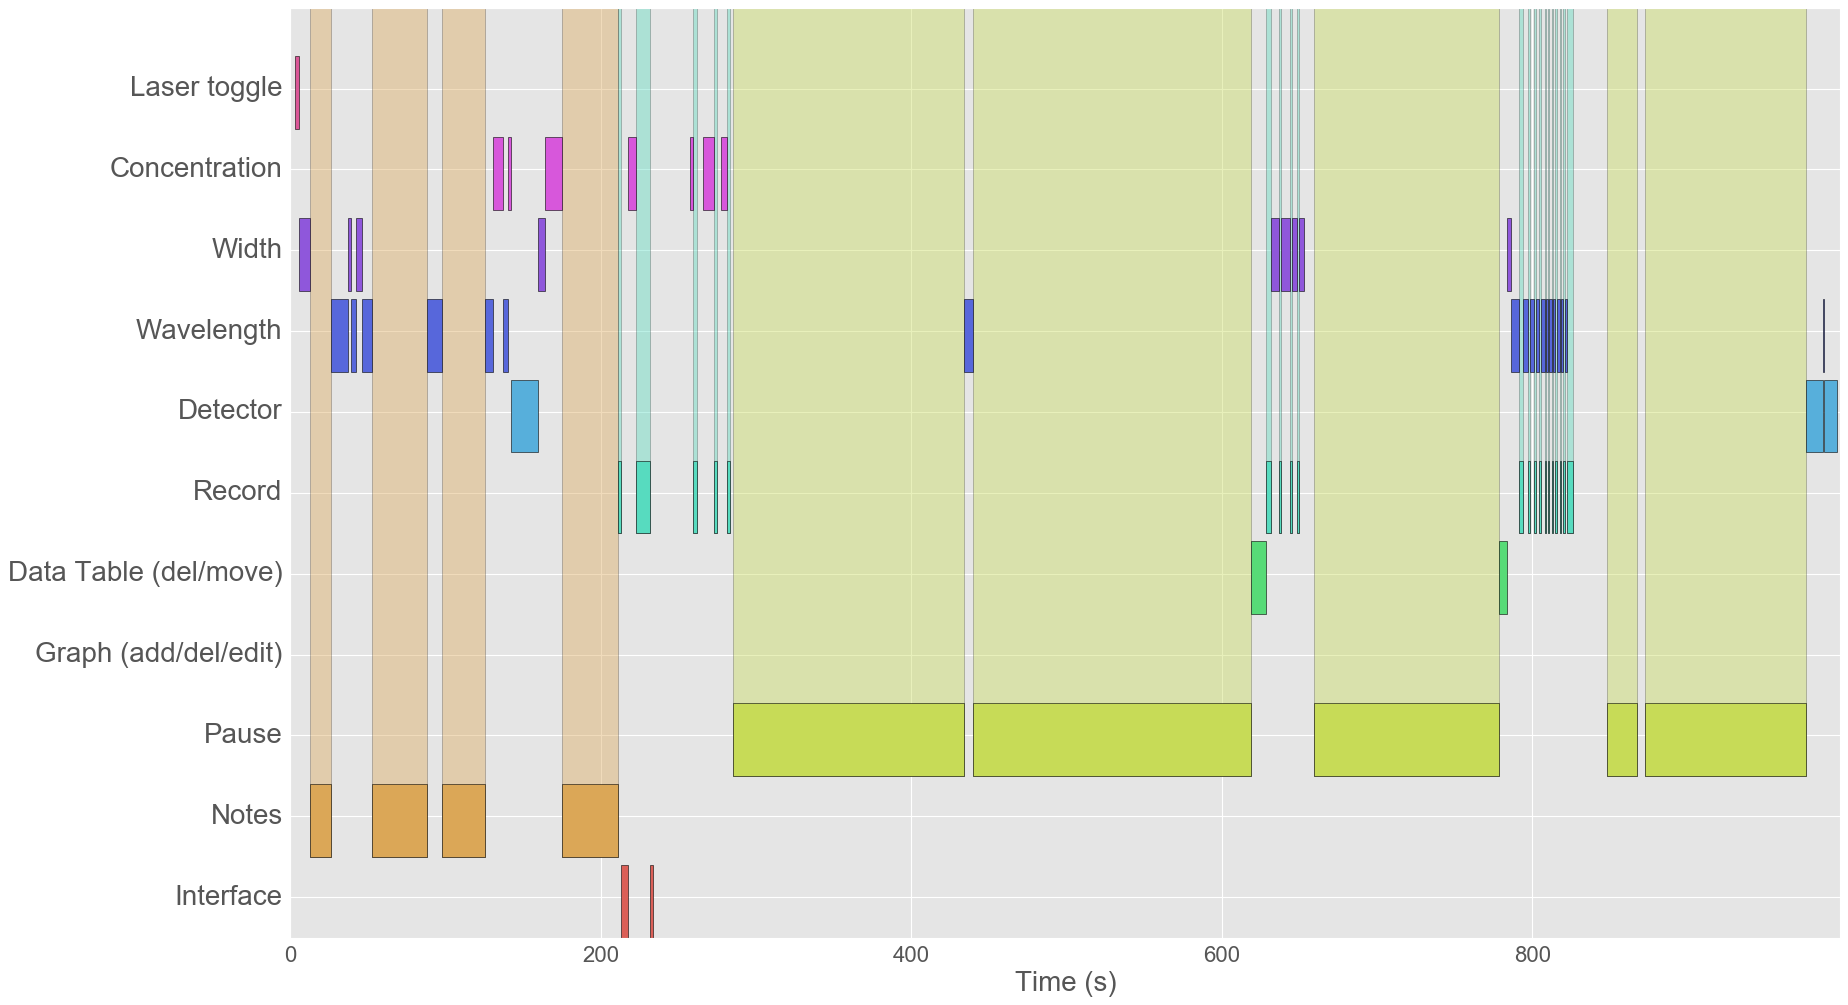

In [17]:
plot_barGraph_new(df, '', family_plot_order,ignore=[])

## Same viz, more freedom
### We can also plot without the sequence, giving us more freedom in how we want to plot things

For each item we wish the plot we comput the time coordinates of that action using functions previously developed in the repository sperez8/iLab-viz. See: [https://github.com/sperez8/iLab-viz/blob/master/log_visualization_maker.ipynb]

In [18]:
def action_usage(df,column,regex):
    '''Given a regex, we detect its use using a particular column
    and then extract a list of time coordinates for when
    they were used. These coordinates are in the format (start_time, duration)
    
    Args:
        df (Pandas dataframe): The dataframe to search in.
        column (str): The column where the action regex might be logged (usualy the Family column)
        regex (str): The regex or often the name of the action family to search for in the column.    

    Returns:
        A list of tuples with start times of the regex and it's duration [(start1,duration1),(start2,duration2),...]
    '''
    if df[df[column].str.contains(regex,na=False)].isnull().values.all():
        return [(0,0)]
    else:
        timecoords = zip(df[df[column].str.contains(regex,na=False)]['Time'],df[df[column].str.contains(regex,na=False)]['Duration'])
        return clean_coords(timecoords)

def clean_coords(coords_brocken_up):
    #since the coordinates all subsequent in time, we want to merge them to clean them up.
    #For example:
    # coords_brocken_up = [(0,2),(2,5),(7,2)]
    # coords -> [(0,9)]
    while True:
        coords = merge_usage(coords_brocken_up,coords_brocken_up)
        if coords == coords_brocken_up:
            return coords
        else:
            coords_brocken_up = coords

def intersect_usage(x,y):
    '''
    Given two lists of coordinates, we find the intersect of comon time coordinates and return the new coordinates.
    These coordinates are in the format (start_time, duration)
    
    Args:
        x (list): One set of coordinates
        y (list): A second set of coordinates

    Returns:
        A list of tuples with a intersect of start and duration coordinates [(start1,duration1),(start2,duration2),...]
        
    For example:
        x = [(0,1),(2,3),(10,3)] #0,2,3,4,10,11,12
        y = [(0,2),(3,1),(9,2),(12,2)] #0,1,3,9,10,12,13
        then intersect_usage(x,y) -> [(0, 1), (3, 1), (10, 1), (12, 1)] #0,3,10,12

    '''
    x.sort() #sort them by start time
    y.sort()
    intersect = []
    
    #for pairs of coordinates, we check if we can capture intersect
    while len(x) > 0 and len(y) > 0:
        (sx,dx) = x[0]
        (sy,dy) = y[0]

        if sx == sy: #if same start times, find min duration
            intersect.append((sx,min(dx,dy)))
            if dx<dy:
                x.pop(0)
            else:
                y.pop(0)             
        elif sx < sy and sx+dx > sy: # if they overlap
            if sx+dx >= sy+dy: #if one coordinate bounds the other
                intersect.append((sy,dy)) #we add that inner coordinate
                y.pop(0) #and remove it
            else: #if no bounding, then just overlap
                intersect.append((sy,dx - (sy-sx))) #add the new coordinate with latest start time
                x.pop(0) #and remove the earliest one
        elif sy < sx and sy+dy > sx: # if they overlap (opposite scenario)
            if sy+dy >= sx+dx: #if one coordinate bounds the other (opposite scenario)
                intersect.append((sx,dx)) #we add that inner coordinate
                x.pop(0) #and remove it
            else:
                intersect.append((sx,dy - (sx-sy))) #add the new coordinate with latest start time
                y.pop(0) #and remove the earliest one
        else:
            #there was no intersect so we remove the earliest coordinate
            if sx < sy:
                x.pop(0)
            else:
                y.pop(0)

    return intersect
            
def merge_usage(x,y):
    '''
    Given two lists of coordinates, we merged them and return the new coordinates.
    These coordinates are in the format (start_time, duration)
    
    Args:
        x (list): One set of coordinates
        y (list): A second set of coordinates

    Returns:
        A list of tuples with merged start and duration coordinates [(start1,duration1),(start2,duration2),...]
        
    For example:
        x = [(0,1),(2,3),(10,3)] #0,2,3,4,10,11,12
        y = [(0,2),(3,1),(9,2),(12,2)] #0,1,3,9,10,12,13
        then merged(x,y) => [(0, 2), (2, 3), (9, 5)] #0,1,2,3,4,9,10,11,12,13

    '''
    
    x = x+y #we put all the coordinates in one list
    
    x = list(set(x)) #remove duplicate coordinates
    x.sort() #sort them by start time
    
    if len(x)==1:
        return x
    
    merged = []
    
    
    #for pairs of coordinates, we check if we can merged them
    for i,(s1,d1) in enumerate(x):
        if i != len(x)-1: 
            s2,d2 = x[i+1] #get next coordinates
#             print s1,d1,s2,d2
            if s1 == s2: #if same start times, find max duration
                merged.append((s1,max(d1,d2)))
                x.remove((s2,d2))
            elif s1+d1 >= s2+d2: #if one coordinate bounds the other
                merged.append((s1,d1)) #we add that coordinate
                x.remove((s2,d2)) #and remove the other
            elif s1+d1 >= s2: # if they overlap
                new_duration = d2 + s2-s1 #we calculate a new duration
                merged.append((s1,new_duration)) #add the new coordinate with earliest start time
                x.remove((s2,d2)) #and remove the other
            else:
                merged.append((s1,d1))
        else:
            #these are the last coordinates of x and haven't been merged yet, 
            # so we try to merge them with the previous coordinates
            if s1 <= merged[-1][0]+merged[-1][1]:
                new_start = merged[-1][0]
                new_duration = d1 + s1 - merged[-1][0]
                merged[-1] = (new_start,new_duration) #extend the duration of the last coordinate
            else: #if it fails, then there is no overlap and we merge them
                merged.append((s1,d1))
    return merged

In [19]:
def plot(df,to_plot,family_name_to_code,function_to_use):
    ax = plt.subplot()
    spacing = 10
    margin = 1
    max_time = 0
    colors = sns.color_palette("hls", len(to_plot))
    
    for i,action in enumerate(to_plot):
        if action in family_name_to_code.keys():
            action_use = action_usage(df,'Family',family_name_to_code[action])
            action_use = clean_coords(action_use)
        else:
            action_use = function_to_use[action](df)

            
        if action_use:
            if action in ['Pause','Notes','Record']:
                    ax.broken_barh(action_use,(i*spacing,(spacing)*(len(to_plot)-i)),facecolors=colors[i],linewidth=0.5,edgecolor='k',alpha=0.4)
            max_time = max(max_time,sum(action_use[-1]))
            ax.broken_barh(action_use,(i*spacing,(spacing-margin)),facecolors=colors[i],alpha=1,linewidth=0.5,edgecolor='k')

    #Shape plot
    ax.set_ylim(-2, len(to_plot)*spacing+2)
    ax.set_xlim(0, max_time+2)
    
    #Add labels
    ax.set_xlabel('Time (min)',fontsize=25)
    ax.set_xticks(range(0,int(max_time),60))
    ax.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(spacing/2,len(to_plot)*spacing,spacing))
    ax.set_yticklabels([a.capitalize() for a in to_plot],fontsize=25)
    ax.grid(True)

In [20]:
family_name_to_code = {'Interface':'I',
                        'Pause':'P',
                        'Graph (add/del/edit)':'G',
                        'Data Table (del/move)':'Dt',
                        'Notes':'N',
                        'Record':'M',
                        'Detector':'Vd',
                        'Wavelength':'Vw',
                        'Width':'Vc',
                        'Concentration':'Vs',
                        'Laser toggle':'Vl',
                        }

function_to_use = {}

to_plot = ['Interface','Notes','Pause','Graph (add/del/edit)','Data Table (del/move)','Record','Detector','Wavelength','Width','Concentration','Laser toggle']

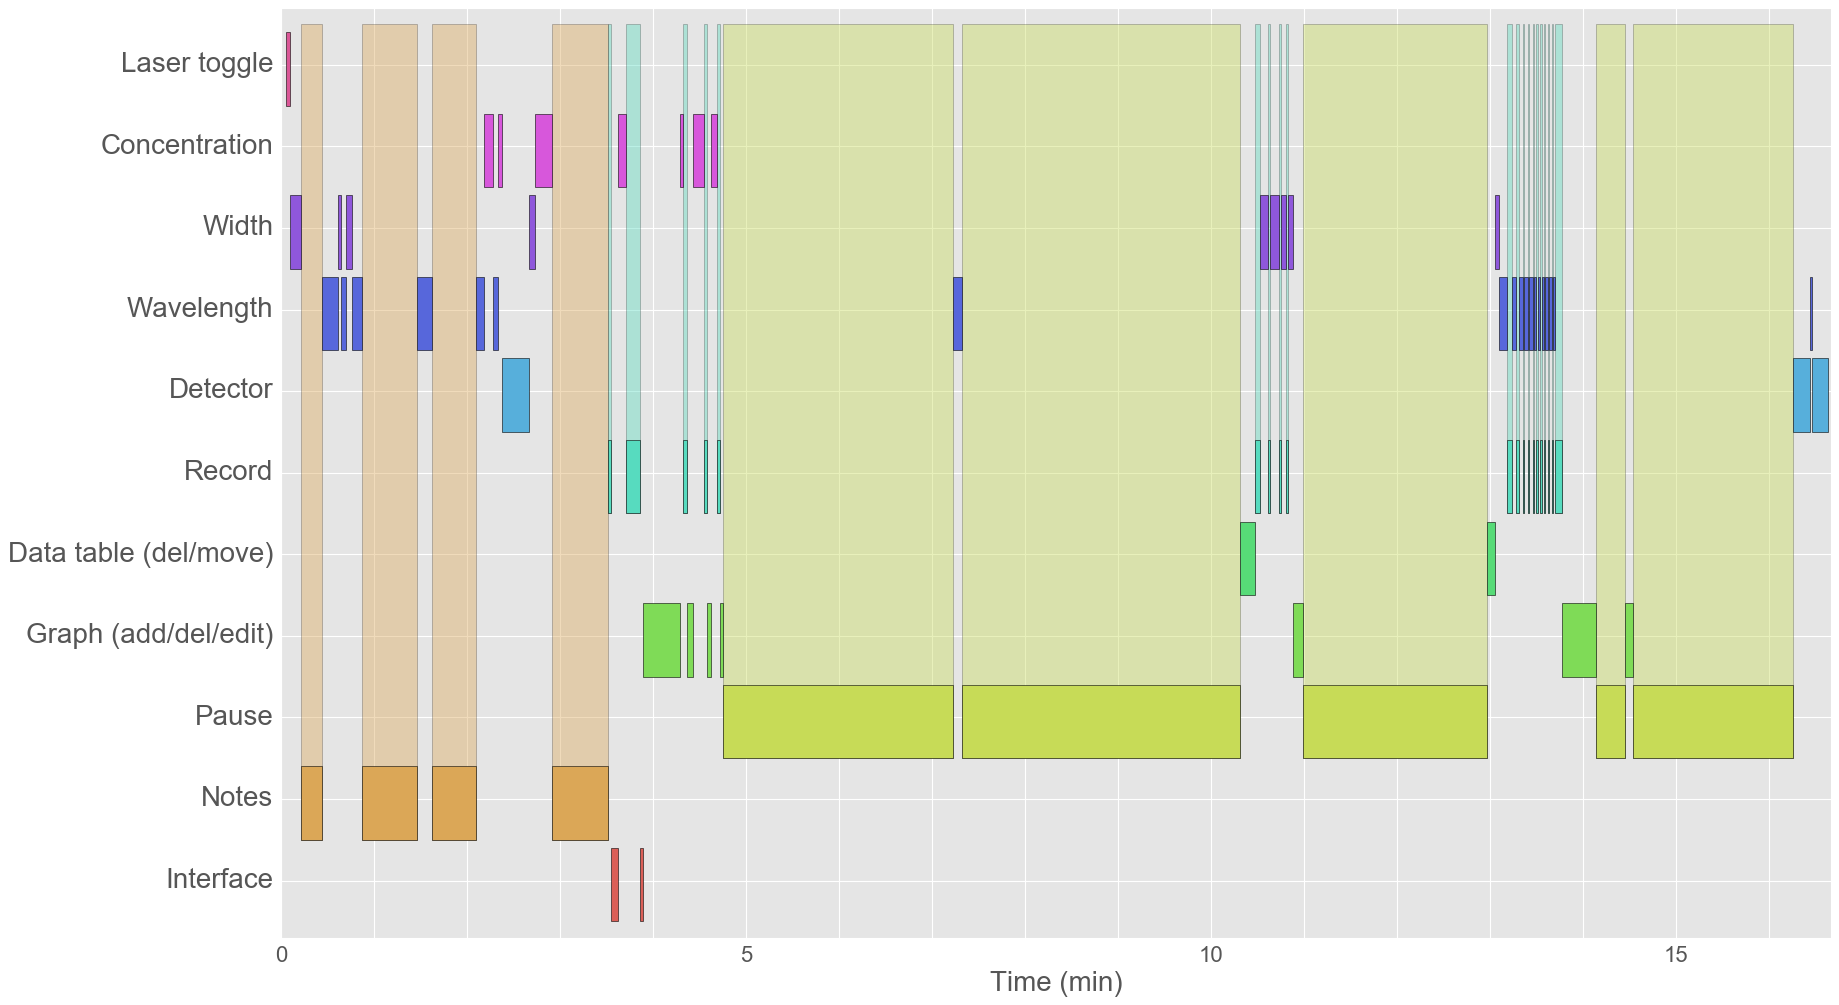

In [21]:
plot(df,to_plot,family_name_to_code,function_to_use)